# K-means in pyspark

* Se implementa K-means en pyspark
* Se calculan métricas de decision y evaluación de kmeans

### Referencias
Ref-1: Pramod (2022). Ch. 8.

In [5]:
# for saving dataset from internet

#import pandas as pd
#data = pd.read_csv("https://raw.githubusercontent.com/Apress/machine-learning-with-pyspark/master/chapter_7_Clustering/iris_dataset.csv")
#data.to_csv("/home/walter/Documents/serie-notas/z_data/20221004_iris_data_again/data.csv", index=False)

In [6]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .master('local[4]')
    .appName('Kmeans')
    .getOrCreate()
)

spark

22/10/04 05:58:39 WARN Utils: Your hostname, notebook resolves to a loopback address: 127.0.1.1; using 192.168.0.18 instead (on interface wlp9s0)
22/10/04 05:58:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/04 05:58:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/04 05:58:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Load

In [8]:
df = spark.read.csv("/home/walter/Documents/serie-notas/z_data/20221004_iris_data_again/data.csv", header=True)
df.show(5, False)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|5.1         |3.5        |1.4         |0.2        |setosa |
|4.9         |3.0        |1.4         |0.2        |setosa |
|4.7         |3.2        |1.3         |0.2        |setosa |
|4.6         |3.1        |1.5         |0.2        |setosa |
|5.0         |3.6        |1.4         |0.2        |setosa |
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



# Exploratory

In [9]:
# sizing
print(df.count(), len(df.columns))

150 5


In [11]:
# Schema
df.printSchema()

root
 |-- sepal_length: string (nullable = true)
 |-- sepal_width: string (nullable = true)
 |-- petal_length: string (nullable = true)
 |-- petal_width: string (nullable = true)
 |-- species: string (nullable = true)



In [12]:
# validate class balance
df.groupBy('species').count().show()

+----------+-----+
|   species|count|
+----------+-----+
| virginica|   50|
|versicolor|   50|
|    setosa|   50|
+----------+-----+



# Preprocessing

In [13]:
from pyspark.sql.types import FloatType

def recast_to_float(df, cols):
    res = df
    for c in cols:
        res = res.withColumn(c, res[c].cast(FloatType()))

    return res

In [18]:
# recast to float
float_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

df = recast_to_float(df, float_cols)

# rename label
df = df.withColumnRenamed('species', 'label')

df.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- label: string (nullable = true)



# Preprocessing for modeling 

In [19]:
from pyspark.ml.feature import VectorAssembler

features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

vec_assembler = VectorAssembler(inputCols=features, outputCol='features')
features_df = vec_assembler.transform(df)
model_df = features_df.select('features', 'label')
model_df.show(5, False)

# Aquí faltó normalizar!!!

+----------------------------------------------------------------------------+------+
|features                                                                    |label |
+----------------------------------------------------------------------------+------+
|[5.099999904632568,3.5,1.399999976158142,0.20000000298023224]               |setosa|
|[4.900000095367432,3.0,1.399999976158142,0.20000000298023224]               |setosa|
|[4.699999809265137,3.200000047683716,1.2999999523162842,0.20000000298023224]|setosa|
|[4.599999904632568,3.0999999046325684,1.5,0.20000000298023224]              |setosa|
|[5.0,3.5999999046325684,1.399999976158142,0.20000000298023224]              |setosa|
+----------------------------------------------------------------------------+------+
only showing top 5 rows



# Modeling

In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator # para silhouette
import matplotlib.pyplot as plt

# defino función de inercia para decidir k
# Esta función es la clave del ejercicio!
def kmeans_metrics(df, k_max):
    '''
    Calculo la inercia y silhouette score del problema en el rango k = [2, k_max - 1]
    '''
    errors = []
    sil_score = []

    for k in range(2,k_max):
        kmeans = KMeans(featuresCol='features', k=k)
        model = kmeans.fit(df)
        intra_distance = model.summary.trainingCost
        errors.append(intra_distance)

        predictions = model.transform(df)
        evaluator = ClusteringEvaluator()
        sil = evaluator.evaluate(predictions)
        sil_score.append(sil)

    return errors, sil_score


In [35]:
list_inertia, sil_score = kmeans_metrics(model_df, 10)

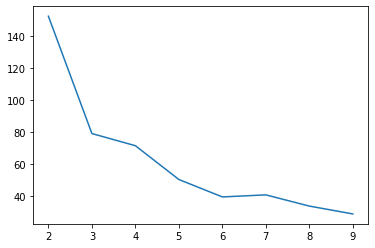

In [36]:
plt.plot(range(2,10), list_inertia)
plt.show()
# se pueden tomar 3 o 5 clusters

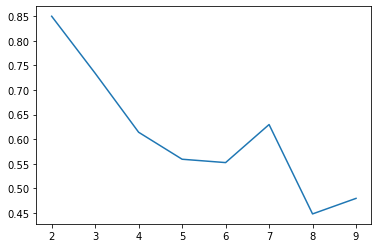

In [39]:
plt.plot(range(2,10), sil_score)
plt.show()
# sil me asegura que los valores de sil para k=3 son mejores que para k=5. Decido K=3

In [43]:
# model
kmeans = KMeans(featuresCol='features', k=3)
model = kmeans.fit(model_df)
res = model.transform(model_df)
res.show(5, False)

+----------------------------------------------------------------------------+------+----------+
|features                                                                    |label |prediction|
+----------------------------------------------------------------------------+------+----------+
|[5.099999904632568,3.5,1.399999976158142,0.20000000298023224]               |setosa|1         |
|[4.900000095367432,3.0,1.399999976158142,0.20000000298023224]               |setosa|1         |
|[4.699999809265137,3.200000047683716,1.2999999523162842,0.20000000298023224]|setosa|1         |
|[4.599999904632568,3.0999999046325684,1.5,0.20000000298023224]              |setosa|1         |
|[5.0,3.5999999046325684,1.399999976158142,0.20000000298023224]              |setosa|1         |
+----------------------------------------------------------------------------+------+----------+
only showing top 5 rows



In [44]:
# aquí se puede evaluar como anda el algoritmo respecto a un gt.
# igual esto no es supervisado.
res.groupBy('label', 'prediction').count().show()

+----------+----------+-----+
|     label|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
| virginica|         0|   14|
|versicolor|         0|   47|
|    setosa|         1|   50|
|versicolor|         2|    3|
+----------+----------+-----+

